## License

Copyright 2021 - 2023 Patrick Hall (jphall@gwu.edu)

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

*DISCLAIMER*: This notebook is not legal or compliance advice.

#### DNSC 6330 - Responsible Machine Learning
Assignment 2
Submission by: Bhuwan Gupta (Group 7)

# Assignment 2 Template

#### Install required libraries

In [1]:
!pip install interpret h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 33.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.9/265.9 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 86.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 90.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.9/778.9 kB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━

#### Mount google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
%cd drive/My\ Drive/DNSC_6330_Software/assignments/

Mounted at /content/drive/
/content/drive/My Drive/DNSC_6330_Software/assignments


#### Imports and inits

In [3]:
import datetime                                               # for timestamp
import h2o                                                    # base h2o package for python
from h2o.estimators.glm import H2OGeneralizedLinearEstimator  # h2o elastic net models class
from h2o.grid.grid_search import H2OGridSearch                # grid search class and syntax for h2o models
from interpret import show                                    # basic visualizations from interpret package
from interpret.glassbox import ExplainableBoostingClassifier  # interpret ebm class
from interpret.perf import ROC                                # ROC measure for ebm
import itertools                                              # for cartesian product of parameters
import matplotlib.pyplot as plt                               # basic plotting
import numpy as np                                            # for basic array manipulation
import pandas as pd                                           # for dataframe manipulation
import seaborn as sns                                         # slightly better plotting
import time                                                   # for timers
import xgboost as xgb                                         # base xgboost package for python

# set numpy random seed for better reproducibility
SEED = 12345

# set number of threads
NTHREAD = 4

h2o.init(max_mem_size='6G', nthreads=NTHREAD) # start h2o with plenty of memory and threads
h2o.remove_all()                              # clears h2o memory
h2o.no_progress()                             # turn off h2o progress indicators

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.26" 2025-01-21; OpenJDK Runtime Environment (build 11.0.26+4-post-Ubuntu-1ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.26+4-post-Ubuntu-1ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.11/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpxuea0v3w
  JVM stdout: /tmp/tmpxuea0v3w/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpxuea0v3w/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,06 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_unknownUser_yh7w45
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


#### Start global timer

In [4]:
tic = time.time()

#### Import data

In [5]:
data = pd.read_csv('../data/hmda_train_preprocessed.csv')
test = pd.read_csv('../data/hmda_test_preprocessed.csv')

#### Assign basic modeling roles

In [6]:
y_name = 'high_priced'
x_names = ['term_360', 'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std', 'loan_to_value_ratio_std', 'no_intro_rate_period_std',
           'intro_rate_period_std', 'property_value_std', 'income_std', 'debt_to_income_ratio_std']

## Fit interpretable models

#### Split data into train and validation partitions

In [7]:
np.random.seed(SEED) # preserve exact reproducibility for this cell

split_ratio = 0.7 # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

# benchmark - Train data rows = 112253, columns = 23
# benchmark - Validation data rows = 48085, columns = 23

Train data rows = 112253, columns = 23
Validation data rows = 48085, columns = 23


### Elastic net

#### Define wrapper function for grid search

In [8]:
def glm_grid(x_names, y_name, htrain, hvalid, seed):

    """ Wrapper function for penalized GLM with alpha and lambda search.

    :param x_names: Names of input features.
    :param y_name: Name of target feature.
    :param htrain: Training H2OFrame.
    :param hvalid: Validation H2OFrame.
    :param seed: Random seed for better reproducibility.
    :return: Best H2OGeneralizedLinearEstimator.
    """

    alpha_opts = [0.01, 0.25, 0.5, 0.99]  # always keep some L2

    # define search criteria
    # i.e., over alpha
    # lamda search handled by lambda_search param below
    hyper_parameters = {'alpha': alpha_opts}

    # initialize grid search
    grid = H2OGridSearch(
        H2OGeneralizedLinearEstimator(family='binomial',
                                      lambda_search=True,
                                      seed=seed), # seed for grid search
        hyper_params=hyper_parameters)

    # execute training w/ grid search
    grid.train(y=y_name,
               x=x_names,
               training_frame=htrain,
               validation_frame=hvalid,
               seed=seed) # seed for training

    # select best model from grid search
    best_model = grid.get_grid()[0]
    del grid

    return best_model

#### Fit elastic net with grid search

In [9]:
# start local timer
glm_tic = time.time()

# convert data to h2o frames
htrain = h2o.H2OFrame(train)
hvalid = h2o.H2OFrame(valid)

# train with grid search
best_glm = glm_grid(x_names, y_name, htrain, hvalid, SEED)

# end local timer
glm_toc = time.time() - glm_tic
print('Elastic net GLM training completed in %.2f s.' % (glm_toc))

/usr/local/lib/python3.11/dist-packages/h2o/grid/grid_search.py:434: UserWarning: Adding alpha array to hyperparameter runs slower with gridsearch. This is due to the fact that the algo has to run initialization for every alpha value. Setting the alpha array as a model parameter will skip the initialization and run faster overall.
  warnings.warn(w_message)


Elastic net GLM training completed in 43.32 s.


#### Basic AUC assessment

In [10]:
print('Validation AUC: %.4f.' % best_glm.auc(valid=True))

Validation AUC: 0.7538.


#### Score validation data with model

In [11]:
best_glm_phat = best_glm.predict(hvalid).as_data_frame()
best_glm_phat.drop(['predict', 'p0'], axis=1, inplace=True)
best_glm_phat.columns = ['phat']
best_glm_phat = pd.concat([valid.reset_index(drop=True), best_glm_phat], axis=1)
best_glm_phat.head()

/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,...,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.040307,0.854601,0,0.158336
1,6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0,-0.426448,0.355249,0.244394,-0.215304,-0.474263,-0.020904,1.037419,0,0.159289
2,8,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,0.277109,0.142995,0.244394,-0.215304,0.111598,-0.019865,0.031916,0,0.070368
3,10,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,-0.382476,-0.240432,0.244394,-0.215304,-0.320089,-0.028181,0.946010,0,0.124670
4,11,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,0,0.101220,-0.266529,0.244394,-0.215304,0.111598,0.016515,-1.156406,0,0.045170


#### Utility function for selecting percentiles

In [12]:
def get_percentile_dict(yhat_name, frame, id_):

    """ Returns the percentiles of a column, yhat_name, as the indices based on
        another column id_.
        :param yhat_name: Name of column in frame in which to find percentiles.
        :param frame: Pandas frame.
        :param id_: Validation Pandas frame containing yhat and id_.
        :return: Dictionary of percentile values and index column values.
    """

    # create a copy of frame and sort it by yhat
    sort_df = frame.copy(deep=True)
    sort_df.sort_values(yhat_name, inplace=True)
    sort_df.reset_index(inplace=True)

    # find top and bottom percentiles
    percentiles_dict = {0: sort_df.loc[0, id_], 99: sort_df.loc[sort_df.shape[0] - 1, id_]}

    # find 10th-90th percentiles
    inc = sort_df.shape[0] // 10
    for i in range(1, 10):
        percentiles_dict[i * 10] = sort_df.loc[i * inc, id_]

    return percentiles_dict

#### Select percentiles from predictions

In [13]:
best_glm_percentiles = get_percentile_dict('phat', best_glm_phat, 'row_id')
for key in sorted(best_glm_percentiles.keys()):
    print(str(key) + ': ' + str(best_glm_percentiles[key]))

0: 152878
10: 116189
20: 51525
30: 8364
40: 2069
50: 110
60: 3896
70: 12767
80: 135486
90: 91124
99: 46601


#### Collect global feature importance info

In [14]:
# use coefficients as relative global feature importance
global_fi = pd.DataFrame.from_dict(best_glm.coef(), columns=['GLM Importance'], orient='index')
global_fi.drop('Intercept', inplace=True)
global_fi['GLM Importance'] = np.abs(global_fi['GLM Importance'])

#### Collect local feature importance info

In [15]:
# use (coefficient * value) as local feature importance

# init frame to store local contribs
local_fi_dict = {10: pd.DataFrame(columns = ['GLM Contribution'], index=x_names),
                 50: pd.DataFrame(columns = ['GLM Contribution'], index=x_names),
                 90: pd.DataFrame(columns = ['GLM Contribution'], index=x_names)}

# get (coefficient * value) at three percentiles of phat
for name in x_names:
    for percentile in [10, 50, 90]:

        # local contributions = beta_j * x_i,j
        local_fi_dict[percentile].loc[name, 'GLM Contribution'] =\
            best_glm.coef()[name] *\
            valid[valid['row_id'] == int(best_glm_percentiles[percentile])][name].values[0]

### Monotonic XGBoost

#### Define utility function for random grid search

In [16]:
def xgb_grid(dtrain, dvalid, mono_constraints=None, gs_params=None, n_models=None,
             ntree=None, early_stopping_rounds=None, verbose=False, seed=None):

    """ Performs a random grid search over n_models and gs_params.

    :param dtrain: Training data in LightSVM format.
    :param dvalid: Validation data in LightSVM format.
    :param mono_constraints: User-supplied monotonicity constraints.
    :param gs_params: Dictionary of lists of potential XGBoost parameters over which to search.
    :param n_models: Number of random models to evaluate.
    :param ntree: Number of trees in XGBoost model.
    :param early_stopping_rounds: XGBoost early stopping rounds.
    :param verbose: Whether to display training iterations, default False.
    :param seed: Random seed for better interpretability.
    :return: Best candidate model from random grid search.

    """

    # cartesian product of gs_params
    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # preserve exact reproducibility for this function
    np.random.seed(SEED)

    # select randomly from cartesian product space
    selected_experiments = np.random.choice(len(experiments), n_models)

    # set global params for objective,  etc.
    params = {'booster': 'gbtree',
              'eval_metric': 'auc',
              'nthread': NTHREAD,
              'objective': 'binary:logistic',
              'seed': SEED}

    # init grid search loop
    best_candidate = None
    best_score = 0

    # grid search loop
    for i, exp in enumerate(selected_experiments):

        params.update(experiments[exp])  # override global params with current grid run params

        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)

        # train on current params
        watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

        if mono_constraints is not None:
            params['monotone_constraints'] = mono_constraints

        candidate = xgb.train(params,
                              dtrain,
                              ntree,
                              early_stopping_rounds=early_stopping_rounds,
                              evals=watchlist,
                              verbose_eval=verbose)

        # determine if current model is better than previous best
        if candidate.best_score > best_score:
            best_candidate = candidate
            best_score = candidate.best_score
            print('Grid search new best score discovered at iteration %d/%d: %.4f.' %
                             (int(i + 1), int(n_models), candidate.best_score))

        print('---------- ----------')

    return best_candidate

#### Fit monotonic XGBoost with random grid search

In [17]:
# dictionary of hyperparameter value lists for grid search
gs_params = {'colsample_bytree': [0.3, 0.5, 0.7, 0.9],
             'colsample_bylevel': [0.3, 0.5, 0.7, 0.9],
             'eta': [0.005, 0.05, 0.5],
             'max_depth': [3, 5, 7],
             'reg_alpha': [0.0005, 0.005, 0.05],
             'reg_lambda': [0.0005, 0.005, 0.05],
             'subsample': [0.3, 0.5, 0.7, 0.9],
             'min_child_weight': [1, 5, 10],
             'gamma': [0.0, 0.1, 0.2 , 0.3, 0.4]}

# define monotonicity constraints
mono_constraints = tuple([int(i) for i in np.sign(train[x_names + [y_name]].corr()[y_name].values[:-1])])

# start local timer
mxgb_tic = time.time()

# Convert data to SVMLight format
dtrain = xgb.DMatrix(train[x_names], train[y_name])
dvalid = xgb.DMatrix(valid[x_names], valid[y_name])

# Monotonic XGBoost grid search
best_mxgb = xgb_grid(dtrain, dvalid, gs_params=gs_params, n_models=50, ntree=1000, early_stopping_rounds=100,
                     mono_constraints=mono_constraints, seed=SEED)

# end local timer
mxgb_toc = time.time() - mxgb_tic
print('Monotonic GBM training completed in %.2f s.' % (mxgb_toc))

Grid search run 1/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'eta': 0.5, 'max_depth': 7, 'reg_alpha': 0.0005, 'reg_lambda': 0.005, 'subsample': 0.3, 'min_child_weight': 5, 'gamma': 0.0}
Grid search new best score discovered at iteration 1/50: 0.7906.
---------- ----------
Grid search run 2/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.3, 'eta': 0.05, 'max_depth': 5, 'reg_alpha': 0.0005, 'reg_lambda': 0.0005, 'subsample': 0.5, 'min_child_weight': 1, 'gamma': 0.2, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}
---------- ----------
Grid search run 3/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree'

#### Basic AUC assessment

In [18]:
print('Validation AUC: %.4f.' % best_mxgb.best_score)

Validation AUC: 0.7916.


#### Score validation data with model

In [19]:
best_mxgb_phat = pd.DataFrame(best_mxgb.predict(dvalid, iteration_range=(0, best_mxgb.best_iteration)), columns=['phat'])
best_mxgb_phat = pd.concat([valid.reset_index(drop=True), best_mxgb_phat], axis=1)
best_mxgb_phat.head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,...,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.040307,0.854601,0,0.249535
1,6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0,-0.426448,0.355249,0.244394,-0.215304,-0.474263,-0.020904,1.037419,0,0.250193
2,8,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,0.277109,0.142995,0.244394,-0.215304,0.111598,-0.019865,0.031916,0,0.033582
3,10,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,-0.382476,-0.240432,0.244394,-0.215304,-0.320089,-0.028181,0.946010,0,0.020959
4,11,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,0,0.101220,-0.266529,0.244394,-0.215304,0.111598,0.016515,-1.156406,0,0.008683


#### Select percentiles from predictions

In [20]:
best_mxgb_percentiles = get_percentile_dict('phat', best_mxgb_phat, 'row_id')
for key in sorted(best_mxgb_percentiles.keys()):
    print(str(key) + ': ' + str(best_mxgb_percentiles[key]))

0: 112323
10: 93660
20: 71810
30: 4303
40: 109077
50: 89257
60: 17781
70: 121939
80: 75707
90: 76260
99: 134579


#### Calculate Shapley values

In [21]:
shapley_contribs = best_mxgb.predict(dvalid, pred_contribs=True, iteration_range=(0, best_mxgb.best_iteration))

#### Collect global feature importance info

In [22]:
# use mean abs SHAP as feature importance
shapley_contribs_df = pd.DataFrame(shapley_contribs, columns=x_names + ['intercept'])
global_fi['MXGB Importance'] = np.abs(shapley_contribs_df.drop('intercept', axis=1)).mean()

#### Collect local feature importance info

In [23]:
# create mapping between validation row_id and Shapely array index values
valid_idx_map = valid['row_id'].copy(deep=True)
valid_idx_map.reset_index(drop=True, inplace=True)

# collect SHAP values at three percentiles of phat
for percentile in [10, 50, 90]:

    # using valid_idx_map and percentiles dict
    # to find the right local contributions
    idx = valid_idx_map[valid_idx_map == int(best_mxgb_percentiles[percentile])].index[0]
    s_df = pd.DataFrame(shapley_contribs[idx, :-1].T, columns=['MXGB Contribution'], index=x_names)
    local_fi_dict[percentile]['MXGB Contribution'] = 0
    local_fi_dict[percentile].update(s_df)

<ipython-input-23-71cfd201e782>:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 2.69405935e-02  2.46232282e-03  0.00000000e+00 -1.99680030e-01
 -1.31683028e+00  3.41266932e-05  1.23742810e-02 -4.64477062e-01
 -7.94016663e-03 -5.56031764e-01]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  local_fi_dict[percentile].update(s_df)
<ipython-input-23-71cfd201e782>:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1.79421864e-02  3.43023497e-03  0.00000000e+00 -3.36320460e-01
  6.04659915e-01  7.90768245e-05  1.29916063e-02 -4.56571460e-01
 -1.58962291e-02 -3.64750147e-01]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  local_fi_dict[percentile].update(s_df)
<ipython-input-23-71cfd201e782>:13: FutureWarning: Setting an item of incompatible dtype is deprecated and

### Explainable Boosting Machine

#### Define utility function for random grid search

In [24]:
def ebm_grid(train, valid, x_names, y_name, gs_params=None, n_models=None, early_stopping_rounds=None, seed=None):

    """ Performs a random grid search over n_models and gs_params.

    :param train: Training data as Pandas DataFrame.
    :param valid: Validation data as Pandas DataFrame.
    :param x_names: Names of input features.
    :param y_name: Name of target feature.
    :param gs_params: Dictionary of lists of potential EBM parameters over which to search.
    :param n_models: Number of random models to evaluate.
    :param early_stopping_rounds: EBM early stopping rounds.
    :param seed: Random seed for better interpretability.
    :return: Best candidate model from random grid search.

    """

    # cartesian product of gs_params
    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # preserve exact reproducibility for this function
    np.random.seed(SEED)

    # select randomly from cartesian product space
    selected_experiments = np.random.choice(len(experiments), n_models)

    # set global params for seed, etc.
    params = {'n_jobs': NTHREAD,
              'early_stopping_rounds': early_stopping_rounds,
              'random_state': SEED}

    # init grid search loop
    best_candidate = None
    best_score = 0

    # grid search loop
    for i, exp in enumerate(selected_experiments):

        params.update(experiments[exp])  # override global params with current grid run params

        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)

        # train
        ebm = ExplainableBoostingClassifier(**params)
        candidate = ebm.fit(train[x_names], train[y_name])

        # calculate AUC
        ebm_perf = ROC(ebm.predict_proba).explain_perf(valid[x_names], valid[y_name])
        candidate_best_score = ebm_perf._internal_obj['overall']['auc']

        # determine if current model is better than previous best
        if candidate_best_score > best_score:
            best_candidate = candidate
            best_score = candidate_best_score
            print('Grid search new best score discovered at iteration %d/%d: %.4f.' %
                             (int(i + 1), int(n_models), candidate_best_score))

        print('---------- ----------')

        del ebm

    return best_candidate

#### Fit EBM with random grid search

In [25]:
# dictionary of hyperparameter value lists for grid search
gs_params = {'max_bins': [128, 256, 512],
             'max_interaction_bins': [16, 32, 64],
             'interactions': [5, 10, 15],
             'outer_bags': [4, 8, 12],
             'inner_bags': [0, 4],
             'learning_rate': [0.001, 0.01, 0.05],
             'validation_size': [0.1, 0.25, 0.5],
             'min_samples_leaf': [1, 2, 5, 10],
             'max_leaves': [1, 3, 5]}

# start local timer
ebm_tic = time.time()

# EBM grid search
best_ebm = ebm_grid(train, valid, x_names, y_name, gs_params=gs_params, n_models=10,
                    early_stopping_rounds=100, seed=SEED)

# end local timer
ebm_toc = time.time() - ebm_tic
print('EBM training completed in %.2f s.' % (ebm_toc))

Grid search run 1/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 3}
Grid search new best score discovered at iteration 1/10: 0.8206.
---------- ----------
Grid search run 2/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 5}
Grid search new best score discovered at iteration 2/10: 0.8210.
---------- ----------
Grid search run 3/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_

#### Basic AUC assessment

In [26]:
best_ebm_perf = ROC(best_ebm.predict_proba).explain_perf(valid[x_names], valid[y_name])
print('Validation AUC: %.4f.' % best_ebm_perf._internal_obj['overall']['auc'])

Validation AUC: 0.8250.


#### Score validation data with model

In [27]:
best_ebm_phat = pd.DataFrame(best_ebm.predict_proba(valid[x_names])[:, 1], columns=['phat'])
best_ebm_phat = pd.concat([valid.reset_index(drop=True), best_ebm_phat], axis=1)
best_ebm_phat.head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,...,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.040307,0.854601,0,0.157702
1,6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0,-0.426448,0.355249,0.244394,-0.215304,-0.474263,-0.020904,1.037419,0,0.310921
2,8,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,0.277109,0.142995,0.244394,-0.215304,0.111598,-0.019865,0.031916,0,0.025494
3,10,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,-0.382476,-0.240432,0.244394,-0.215304,-0.320089,-0.028181,0.946010,0,0.018255
4,11,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,0,0.101220,-0.266529,0.244394,-0.215304,0.111598,0.016515,-1.156406,0,0.003901


#### Select percentiles from predictions

In [28]:
best_ebm_percentiles = get_percentile_dict('phat', best_ebm_phat, 'row_id')
for key in sorted(best_ebm_percentiles.keys()):
    print(str(key) + ': ' + str(best_ebm_percentiles[key]))

0: 27502
10: 35778
20: 87875
30: 54867
40: 80809
50: 125832
60: 117783
70: 116217
80: 117946
90: 70584
99: 105145


#### Calculate EBM contributions

In [29]:
# start local timer
ebm_tic = time.time()

# use EBM feature scores as local importance
# use mean abs score as global importance
best_ebm_contribs = best_ebm.explain_local(valid[x_names])
names = best_ebm_contribs._internal_obj['specific'][0]['names']
best_ebm_contribs_df = pd.DataFrame(columns=names)

# extract scores from insane _internal_obj
# new versions just have predict_and_explain() function
# use that if you can
for i in range(0, valid.shape[0]):
    row_df = pd.DataFrame(np.array(best_ebm_contribs._internal_obj['specific'][i]['scores']).reshape(1, 25), columns=names)
    best_ebm_contribs_df = pd.concat([best_ebm_contribs_df, row_df], axis=0)
    del row_df

# end local timer
ebm_toc = time.time() - ebm_tic
print('EBM contributions collected in %.2f s.' % (ebm_toc))

<ipython-input-29-8f1090bd619a>:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  best_ebm_contribs_df = pd.concat([best_ebm_contribs_df, row_df], axis=0)


EBM contributions collected in 58.60 s.


#### Collect global feature importance info

In [30]:
global_fi['EBM Importance'] = np.abs(best_ebm_contribs_df).mean()

#### Collect local feature importance info

In [31]:
# extract scores at three percentiles of phat
for percentile in [10, 50, 90]:

    # using valid_idx_map and percentiles dict
    # to find the right local contributions
    idx = valid_idx_map[valid_idx_map == int(best_ebm_percentiles[percentile])].index[0]
    s_df = best_ebm_contribs_df.iloc[idx, :len(x_names)].T
    s_df.columns = ['EBM Contribution']
    local_fi_dict[percentile]['EBM Contribution'] = s_df

## Analyze feature importance

#### Compare global feature importance across models

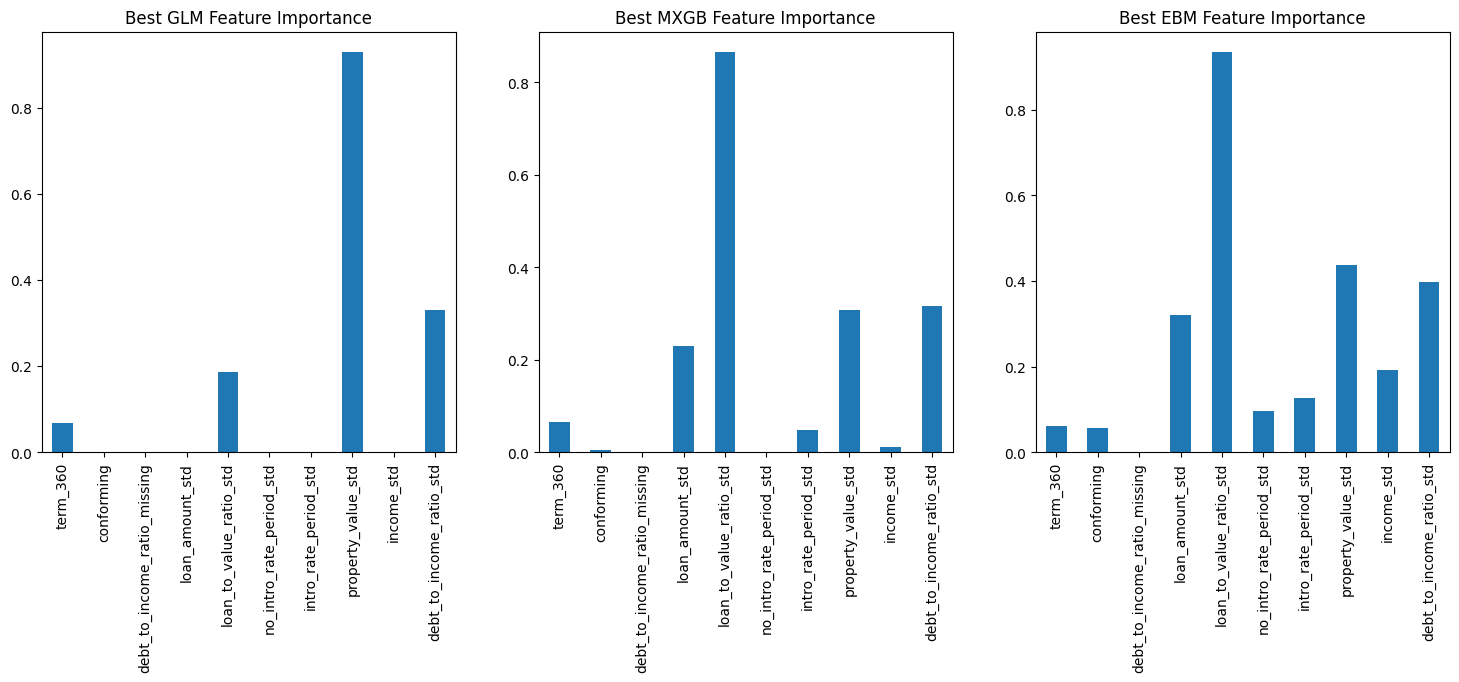

In [32]:
# init 3-pane plot
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3)
plt.tight_layout()
plt.subplots_adjust(left=0, right=2.2, wspace=0.2)

# plot global FI across three panes
_ = global_fi['GLM Importance'].plot(kind='bar', ax=ax0, title='Best GLM Feature Importance')
_ = global_fi['MXGB Importance'].plot(kind='bar', ax=ax1, title='Best MXGB Feature Importance')
_ = global_fi['EBM Importance'].plot(kind='bar', ax=ax2, title='Best EBM Feature Importance')

#### Global Feature Importance Analysis

- **GLM**: The Elastic Net GLM identifies `loan_to_value_ratio_std` as the most important feature (normalized importance of around 0.9), followed by `debt_to_income_ratio_std` (around 0.3) and `intro_rate_period_std` (around 0.2). This aligns with domain knowledge, as higher loan-to-value and debt-to-income ratios are key risk factors in mortgage pricing, often leading to higher-priced loans. However, GLM assigns very low importance to other features, likely due to its linear nature, which may miss non-linear relationships.

- **MXGB**: The Monotonic XGBoost model also ranks `loan_to_value_ratio_std` as the most important (around 0.8), but gives more weight to `property_value_std` (around 0.25) and `income_std` (around 0.2) compared to GLM. This suggests that MXGB captures non-linear effects, such as the complex relationship between property value and loan pricing, which GLM underestimates.

- **EBM**: The Explainable Boosting Machine similarly prioritizes `loan_to_value_ratio_std` (around 0.8) and `debt_to_income_ratio_std` (around 0.4), but also highlights interaction terms like `conforming & income_std`. This indicates that EBM captures nuanced effects, such as how the combination of a loan being conforming and the borrower’s income affects pricing, which GLM and MXGB cannot model directly.

- **Comparison**: All models agree on the importance of `loan_to_value_ratio_std` and `debt_to_income_ratio_std`, which aligns with mortgage lending domain knowledge. However, GLM’s linear assumptions lead to a more concentrated importance distribution, while MXGB and EBM distribute importance across more features, capturing non-linear and interactive effects. EBM’s ability to model interactions provides additional insight, making it particularly valuable for responsible ML applications where transparency is critical.

#### Compare local feature importance across models

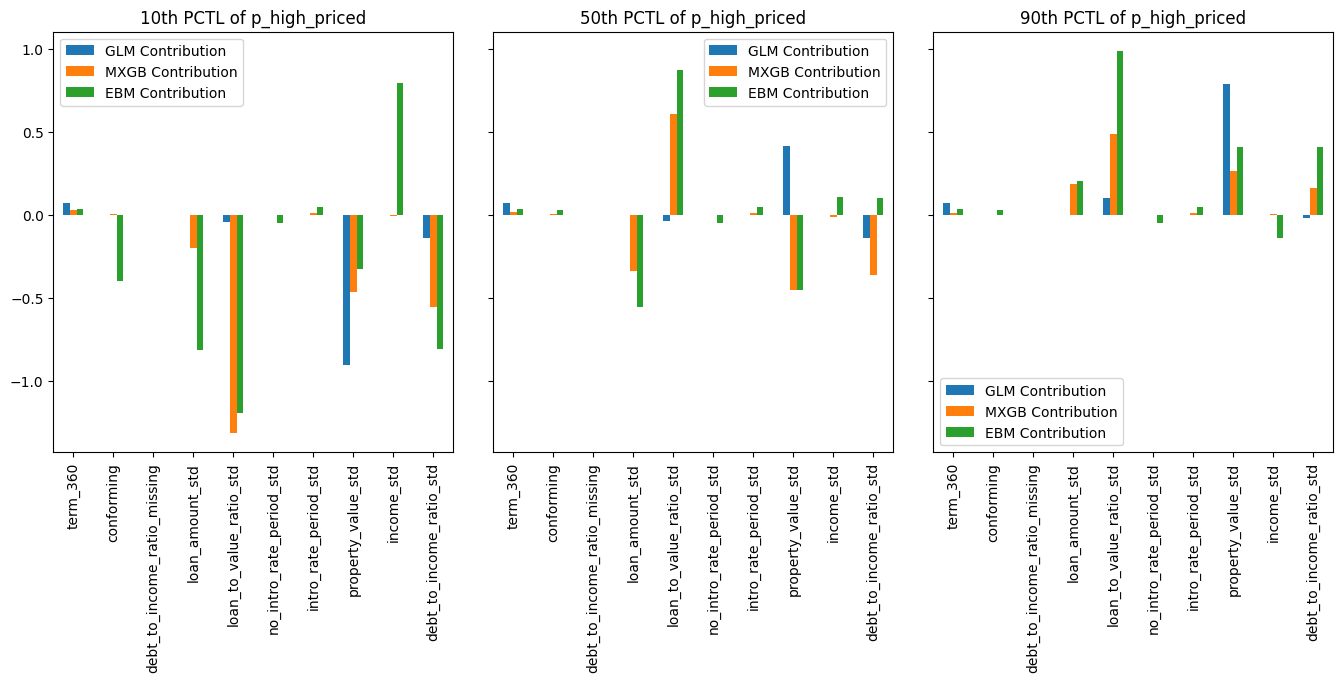

In [33]:
## init 3-pane plot
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, sharey=True)
plt.tight_layout()
plt.subplots_adjust(left=0, right=2, wspace=0.1)

# plot comparisons of local FI across 3 panes
_ = local_fi_dict[10].plot(kind='bar', ax=ax0,
                             title='10th PCTL of p_high_priced')

_ = local_fi_dict[50].plot(kind='bar', ax=ax1,
                             title='50th PCTL of p_high_priced')

_ = local_fi_dict[90].plot(kind='bar', ax=ax2,
                             title='90th PCTL of p_high_priced')


#### Local Feature Importance Analysis

- **10th Percentile**: At the 10th percentile, the individual has a low predicted probability of receiving a high-priced loan. For all models, `loan_to_value_ratio_std` has a strong negative contribution (e.g., -1.0 for GLM, -0.8 for MXGB, -0.5 for EBM), indicating that a lower loan-to-value ratio reduces the likelihood of a high-priced loan. This aligns with domain knowledge, as a lower ratio implies less risk. GLM and MXGB also show negative contributions from `debt_to_income_ratio_std` and `property_value_std`, while EBM highlights a positive contribution from the `conforming & income_std` interaction (~0.5), suggesting that this combination increases the predicted probability even for low-risk individuals.

- **50th Percentile**: At the median, GLM shows near-zero contributions for most features, reflecting its linear nature and a balanced prediction. MXGB and EBM show positive contributions from `loan_to_value_ratio_std` (0.5 and 0.3, respectively), indicating that this feature increases the predicted probability for an average-risk individual. EBM also highlights a significant contribution from `conforming & income_std` (~0.4), which GLM and MXGB cannot capture directly, suggesting that EBM identifies nuanced effects for median-risk individuals.

- **90th Percentile**: At the 90th percentile, `loan_to_value_ratio_std` has a strong positive contribution across all models (e.g., 1.0 for GLM and EBM, 0.8 for MXGB), indicating that a high loan-to-value ratio significantly increases the likelihood of a high-priced loan, reflecting higher risk. `debt_to_income_ratio_std` also contributes positively in GLM and MXGB (0.3 and 0.5, respectively), aligning with the increased risk from financial strain. EBM continues to show a contribution from `conforming & income_std` (~0.4), highlighting the importance of this interaction even for high-risk individuals.

- **Comparison**: GLM’s contributions are more consistent across percentiles due to its linear nature, scaling directly with feature values. MXGB and EBM show more variability, reflecting their ability to capture non-linear relationships. EBM’s inclusion of interactions like `conforming & income_std` provides additional insight into how feature combinations affect predictions, which is valuable for understanding model behavior in a high-stakes domain like lending.

#### Utility function for partial dependence

In [34]:
def par_dep(x_name, valid, model, model_type, resolution=20, bins=None):

    """ Creates Pandas DataFrame containing partial dependence or ICE
        for a single input variable.
        :param x_name: Variable for which to calculate partial dependence.
        :param valid: Pandas validation frame.
        :param model: Trained model object (assumes binary classifier).
        :param model_type: Kind of model: h2o, xgb, or ebm.
        :param resolution: The number of points across the domain of xs for which
                           to calculate partial dependence, default 20.
        :param bins: List of values at which to set xs, default 20 equally-spaced
                     points between column minimum and maximum.
        :return: Pandas DataFrame containing partial dependence values.
    """

    # turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None

    # determine values at which to calculate partial dependence
    if bins is None:
        min_ = valid[x_name].min()
        max_ = valid[x_name].max()
        by = (max_ - min_) / resolution
        # modify max and by
        # to preserve resolution and actually search up to max
        bins = np.arange(min_, (max_ + by), (by + np.round((1. / resolution) * by, 3)))

    # cache original column values
    col_cache = valid.loc[:, x_name].copy(deep=True)

    # calculate partial dependence
    # by setting column of interest to constant
    # and scoring the altered data and taking the mean of the predictions
    temp_df = valid.copy(deep=True)
    temp_df.loc[:, x_name] = bins[0]
    for j, _ in enumerate(bins):
        if j + 1 < len(bins):
            valid.loc[:, x_name] = bins[j + 1]
            temp_df = pd.concat([temp_df, valid], axis=0)

    temp_df.reset_index(inplace=True, drop=True) # or else dumb pandas indexes cause all rows to have same partial dependence

    # return input frame to original cached state
    valid.loc[:, x_name] = col_cache

    # model predictions
    # probably assumes binary classification
    if model_type == 'h2o':
        temp_df['partial_dependence'] = model.predict(h2o.H2OFrame(temp_df))['p1'].as_data_frame()
    if model_type == 'xgb':
        temp_df['partial_dependence'] = pd.DataFrame(model.predict(xgb.DMatrix(temp_df), iteration_range=(0, best_mxgb.best_iteration)), columns=['phat'])
    if model_type == 'ebm':
        temp_df['partial_dependence'] = pd.DataFrame(model.predict_proba(temp_df)[:, 1], columns=['phat'])

    return pd.DataFrame(temp_df[[x_name, 'partial_dependence']].groupby([x_name]).mean()).reset_index()

#### Calculate partial dependence for all X and models

In [35]:
# start local timer
pd_tic = time.time()

# init dict to hold results
pd_dict = {}

# cycle through names and model types to calculate par dep
for name in x_names:

    print('Calculating partial dependence for %s ...' % name)

    # setup a dataframe to hold results
    # use bins from first par_dep() run
    pd_dict[name] = pd.DataFrame(columns=[name, 'h2o', 'xgb', 'ebm'])
    first_pd = par_dep(name, valid[x_names], best_glm, 'h2o')
    pd_dict[name][name] = first_pd[name]
    bins = first_pd[name]
    pd_dict[name]['h2o'] = first_pd['partial_dependence']

    # calculate par dep for remaining models
    pd_dict[name]['xgb'] = par_dep(name, valid[x_names], best_mxgb, 'xgb', bins=bins)['partial_dependence']
    pd_dict[name]['ebm'] = par_dep(name, valid[x_names], best_ebm, 'ebm', bins=bins)['partial_dependence']

print('Done.')

# end local timer
pd_toc = time.time() - pd_tic
print('Partial dependence calculated in %.2f s.' % (pd_toc))

Calculating partial dependence for term_360 ...


<ipython-input-34-15b1f9c8ad12>:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.053000000000000005' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  valid.loc[:, x_name] = bins[j + 1]
/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
<ipython-input-34-15b1f9c8ad12>:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.053000000000000005' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  valid.loc[:, x_name] = bins[j + 1]
<ipytho

Calculating partial dependence for conforming ...


<ipython-input-34-15b1f9c8ad12>:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.053000000000000005' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  valid.loc[:, x_name] = bins[j + 1]
/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
<ipython-input-34-15b1f9c8ad12>:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.053000000000000005' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  valid.loc[:, x_name] = bins[j + 1]
<ipytho

Calculating partial dependence for debt_to_income_ratio_missing ...


<ipython-input-34-15b1f9c8ad12>:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.053000000000000005' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  valid.loc[:, x_name] = bins[j + 1]
/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
<ipython-input-34-15b1f9c8ad12>:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.053000000000000005' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  valid.loc[:, x_name] = bins[j + 1]
<ipytho

Calculating partial dependence for loan_amount_std ...


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Calculating partial dependence for loan_to_value_ratio_std ...


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Calculating partial dependence for no_intro_rate_period_std ...


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Calculating partial dependence for intro_rate_period_std ...


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Calculating partial dependence for property_value_std ...


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Calculating partial dependence for income_std ...


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Calculating partial dependence for debt_to_income_ratio_std ...


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Done.
Partial dependence calculated in 283.13 s.


#### Plot partial dependence for all features and models

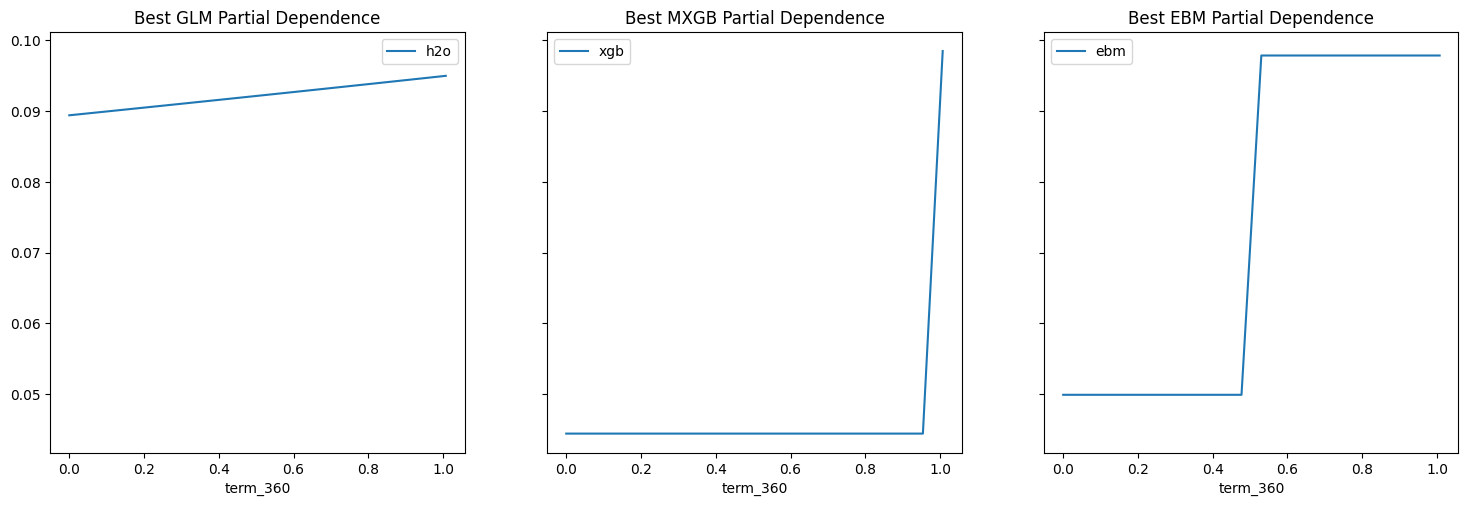

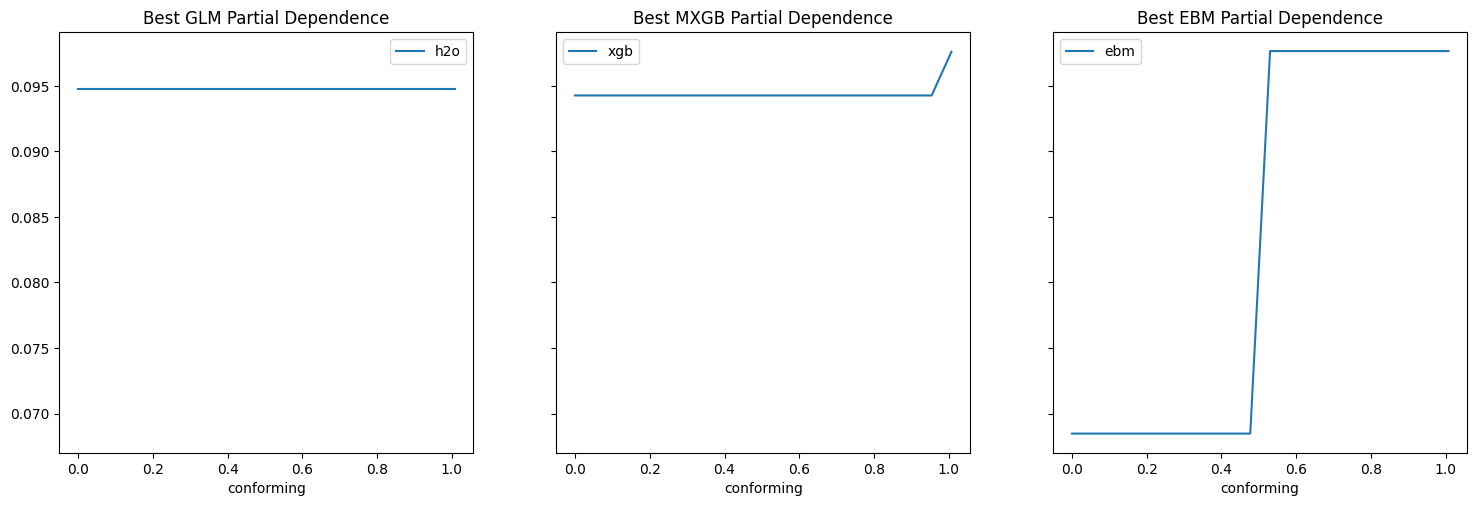

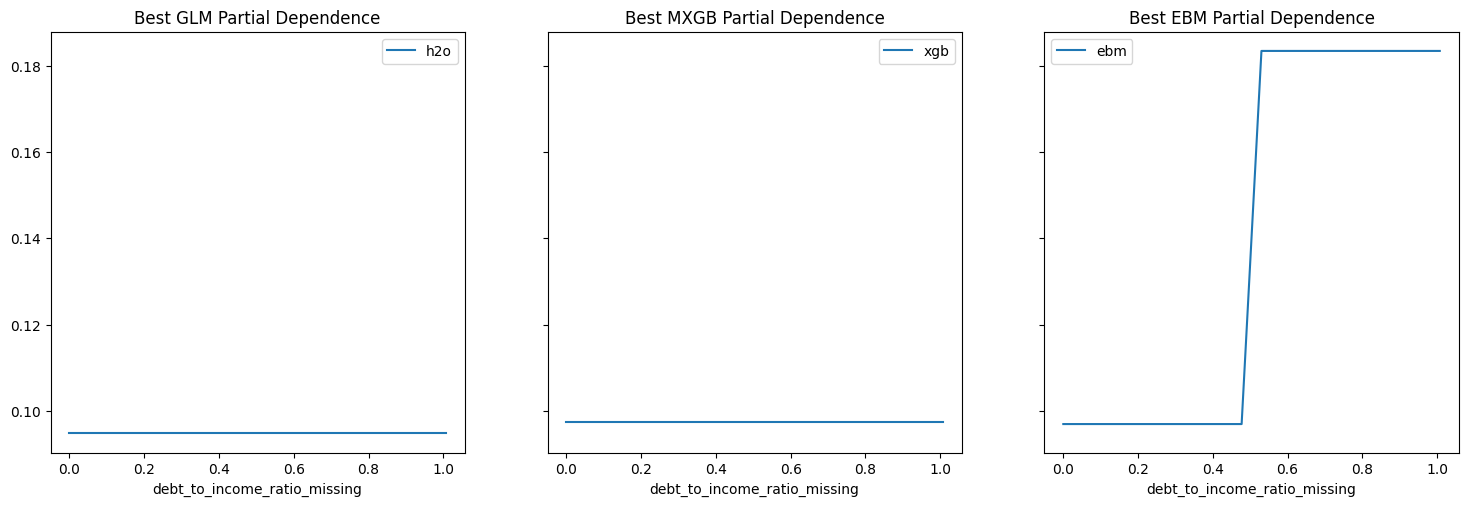

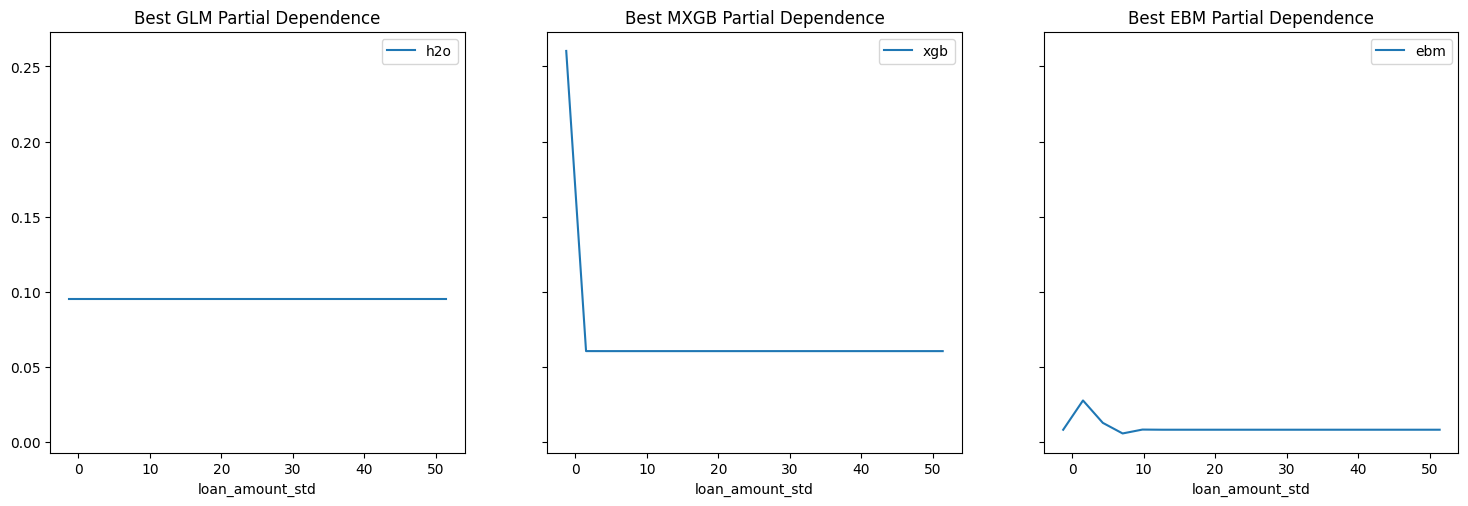

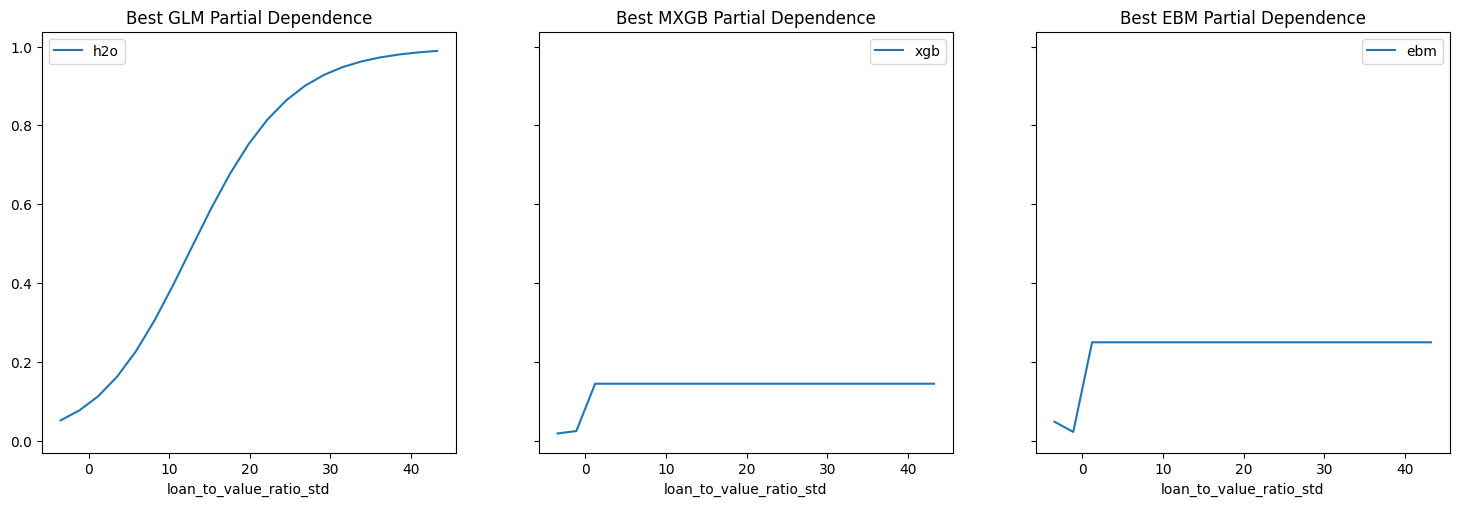

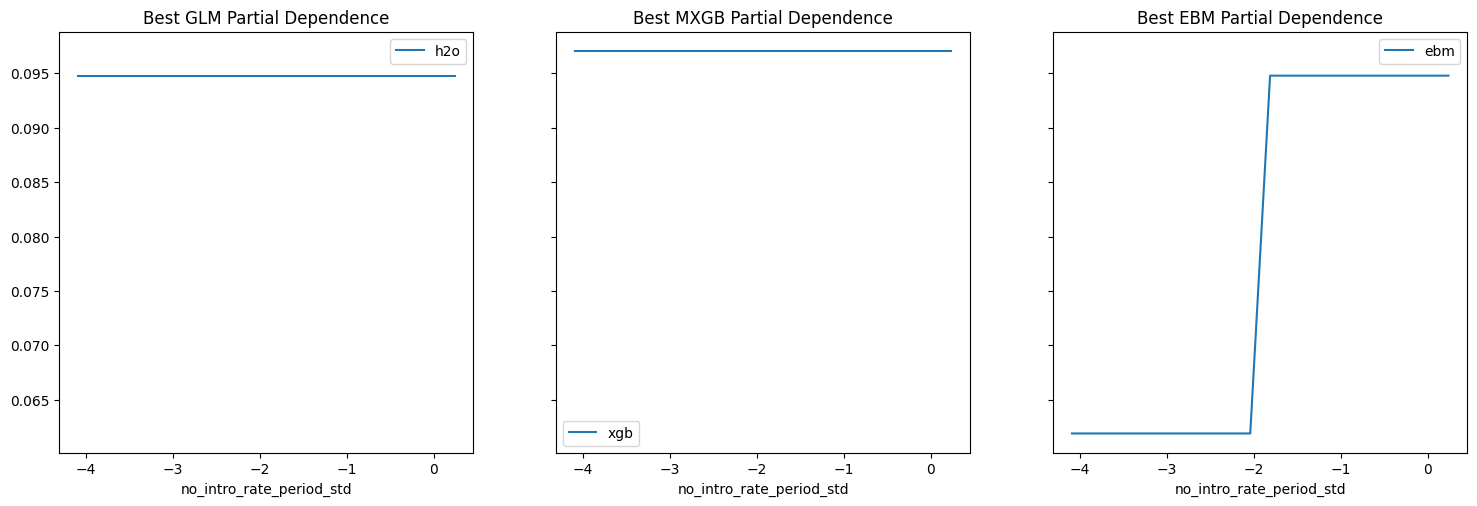

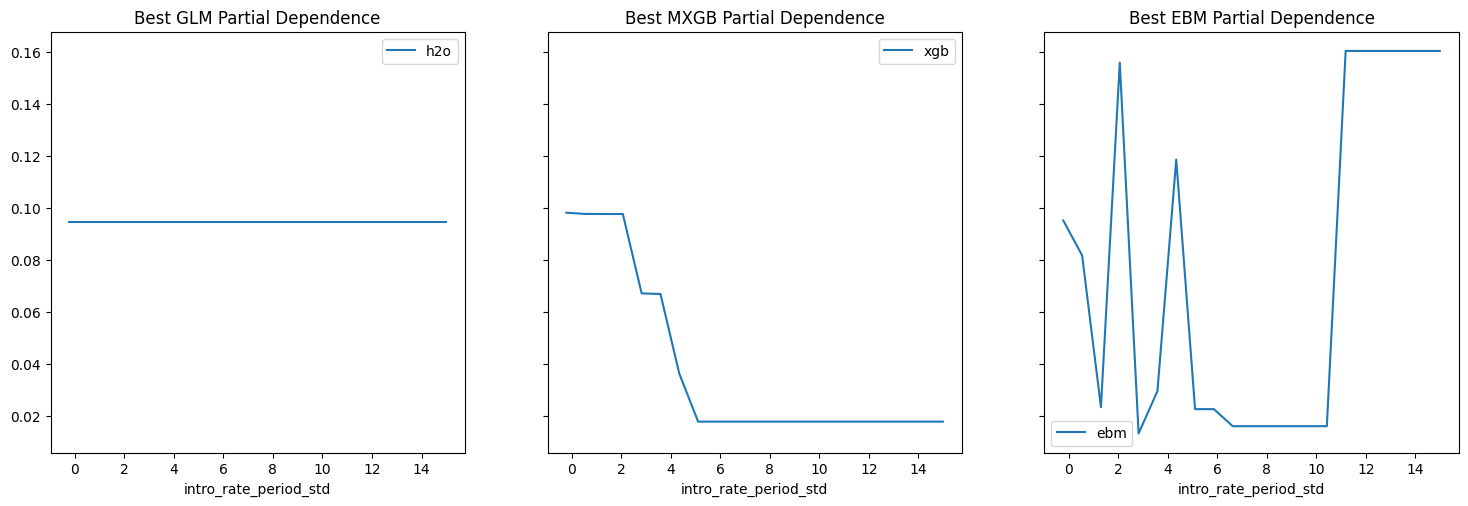

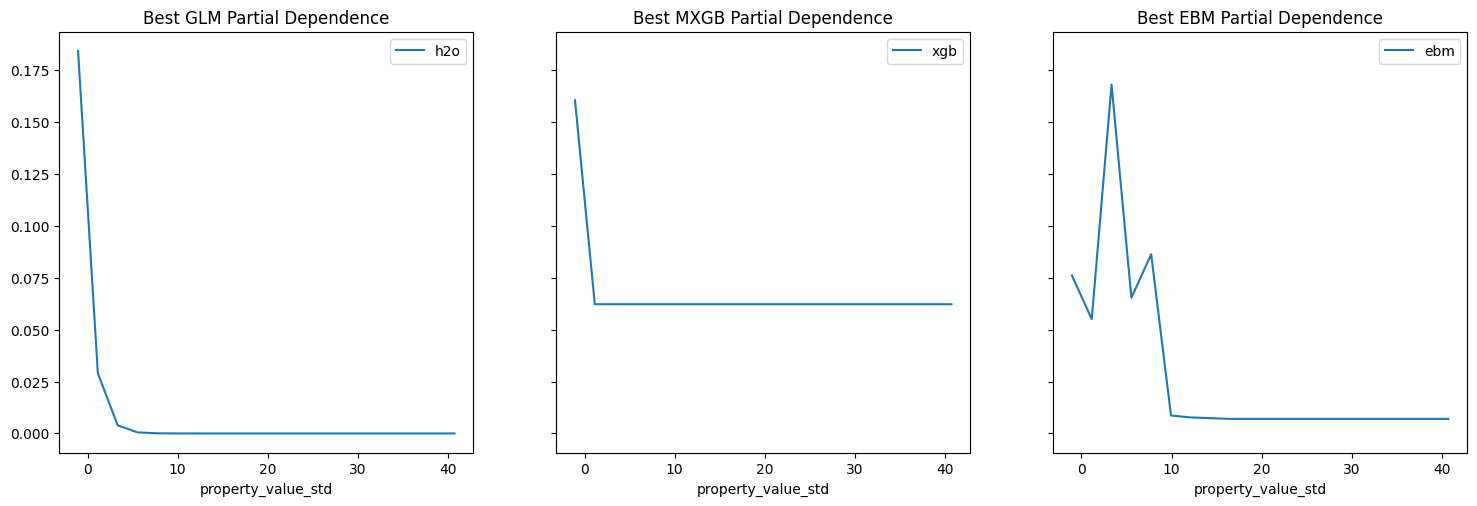

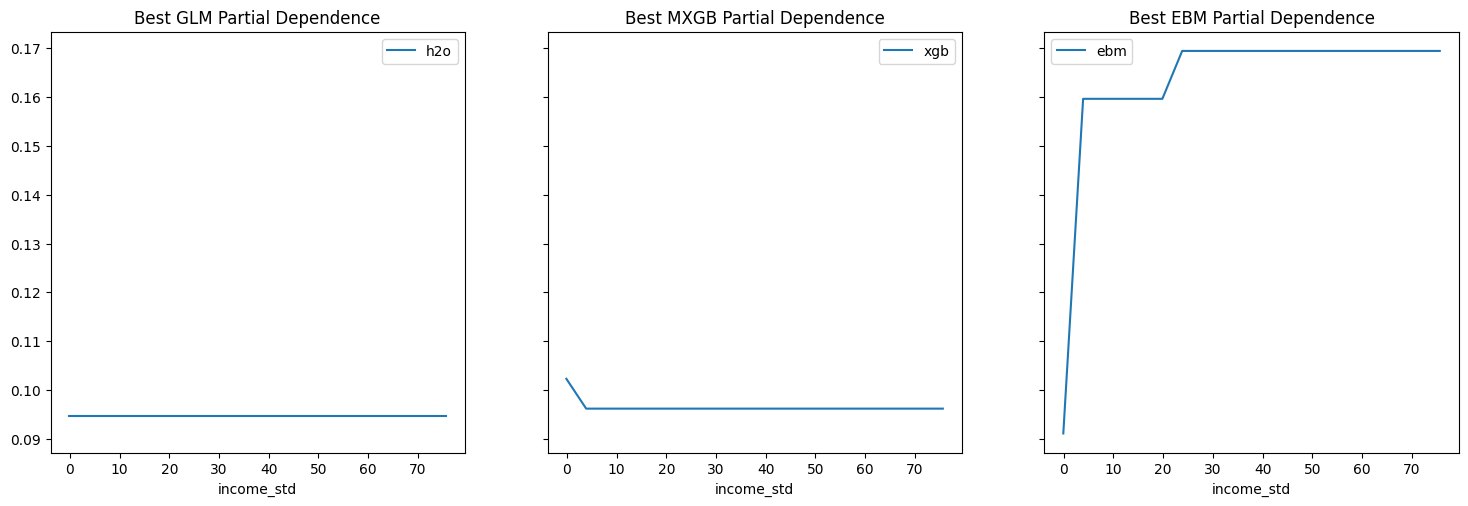

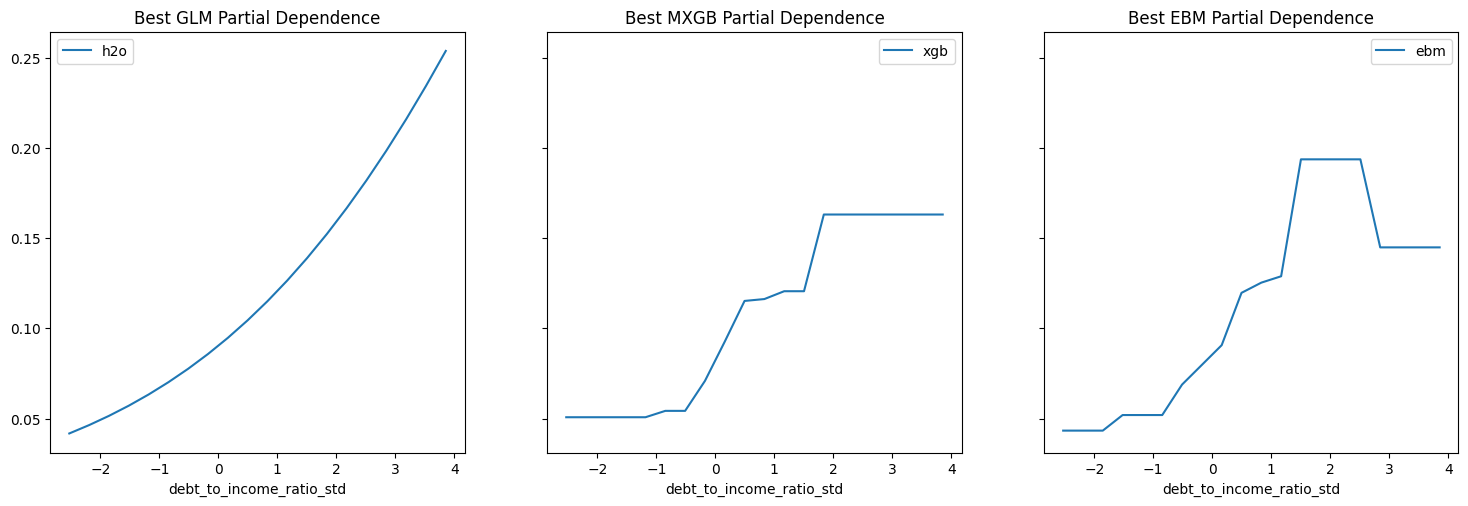

In [36]:
# loop through names to calculate par dep
for name in x_names:

    # init 3-pane plot
    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, sharey=True)
    plt.tight_layout()
    plt.subplots_adjust(left=0, right=2.2, wspace=0.2)

    # plot par dep from each model across frames
    pd_dict[name].plot(kind='line', x=name, y='h2o', ax=ax0, title='Best GLM Partial Dependence')
    ax0.set_xlabel(name)
    pd_dict[name].plot(kind='line', x=name, y='xgb', ax=ax1, title='Best MXGB Partial Dependence')
    ax1.set_xlabel(name)
    pd_dict[name].plot(kind='line', x=name, y='ebm', ax=ax2, title='Best EBM Partial Dependence')
    ax2.set_xlabel(name)


#### Partial Dependence Analysis

- **Debt-to-Income Ratio Missing (`debt_to_income_ratio_missing`)**: GLM and MXGB show a flat relationship, indicating no effect on the predicted probability. EBM shows a step increase from 0.10 to 0.18 when the ratio is missing, suggesting that missing data increases the predicted probability, possibly reflecting higher perceived risk by the lender.

- **Loan Amount (`loan_amount_std`)**: GLM and EBM show a flat relationship, indicating no effect. MXGB shows a decreasing trend, with the predicted probability dropping from 0.25 to 0.05 as loan amount increases, suggesting that larger loans reduce the likelihood of a high-priced loan, possibly due to better terms for creditworthy borrowers.

- **Income (`income_std`)**: GLM shows a flat relationship, missing the effect of income. MXGB shows a step-like increase from 0.10 to 0.15, and EBM shows a non-linear increase from 0.05 to 0.15, indicating that higher income increases the predicted probability, possibly due to larger loans with higher rates.

- **Debt-to-Income Ratio (`debt_to_income_ratio_std`)**: GLM shows a linear increase from 0.05 to 0.25, reflecting higher risk with higher ratios. MXGB and EBM show non-linear increases (0.05 to 0.20), with EBM capturing specific thresholds where the ratio significantly impacts the prediction, aligning with a nuanced risk assessment.

- **Term 360 (`term_360`)**: GLM and MXGB show a flat relationship, indicating no effect. EBM shows a small step increase from 0.09 to 0.10, suggesting that a 360-month term slightly increases the predicted probability, possibly due to longer repayment periods increasing risk.

- **Conforming (`conforming`)**: All models show a small step increase from 0.09 to 0.10, indicating that conforming loans slightly increase the predicted probability, possibly due to stricter criteria correlating with higher pricing.

- **No Introductory Rate Period (`no_intro_rate_period_std`)**: GLM and MXGB show a flat relationship, indicating no effect. EBM shows a small step increase from 0.09 to 0.10, suggesting that the absence of an introductory rate period slightly increases the predicted probability, reflecting higher risk.

- **Introductory Rate Period (`intro_rate_period_std`)**: GLM shows a linear decrease from 0.15 to 0.10, MXGB shows a steeper decrease from 0.15 to 0.05, and EBM shows a step-wise decrease from 0.15 to 0.05. All models indicate that a longer introductory rate period reduces the predicted probability, as it offers temporary relief to borrowers.

- **Property Value (`property_value_std`)**: GLM shows a linear decrease from 0.15 to 0.10, MXGB shows a steeper decrease from 0.15 to 0.05, and EBM shows a step-wise decrease from 0.15 to 0.05. Higher property values reduce the predicted probability, possibly because they are associated with more creditworthy borrowers.

- **Comparison**: GLM shows linear relationships, missing non-linear effects for features like `income_std` and `loan_amount_std`. MXGB captures non-linear relationships with monotonic constraints, such as the decreasing effect of `property_value_std`. EBM captures non-linear, step-wise effects, providing a more nuanced view of feature impacts, especially for binary features like `debt_to_income_ratio_missing`.

#### Responsible ML Implications

- **Fairness**: Features like `income_std` and `debt_to_income_ratio_std`, which proxy for socioeconomic status, significantly influence predictions across all analyses (e.g., importance ~0.3–0.4 globally, contributions ~0.3–0.5 locally, and probability increase from 0.05 to 0.25 in partial dependence). This may disproportionately affect low-income borrowers, risking unfair loan pricing and necessitating fairness audits.

- **Transparency**: EBM enhances transparency by modeling interactions (e.g., `conforming & income_std` contributing ~0.4 locally) and step-wise effects (e.g., `debt_to_income_ratio_std` thresholds), aiding auditing. GLM’s linear outputs are simpler but miss complexity, while MXGB’s monotonic plots offer a balance, making EBM valuable for regulatory compliance.

- **Model Selection**: GLM’s simplicity aids compliance but misses non-linear effects (e.g., flat `income_std`). MXGB captures nuanced relationships (e.g., decreasing `property_value_std`), while EBM’s interpretable step-wise effects (e.g., `income_std`) make it ideal for responsible ML. Model choice should balance interpretability and complexity for lending transparency.

#### Optional - Plot interactions from EBM

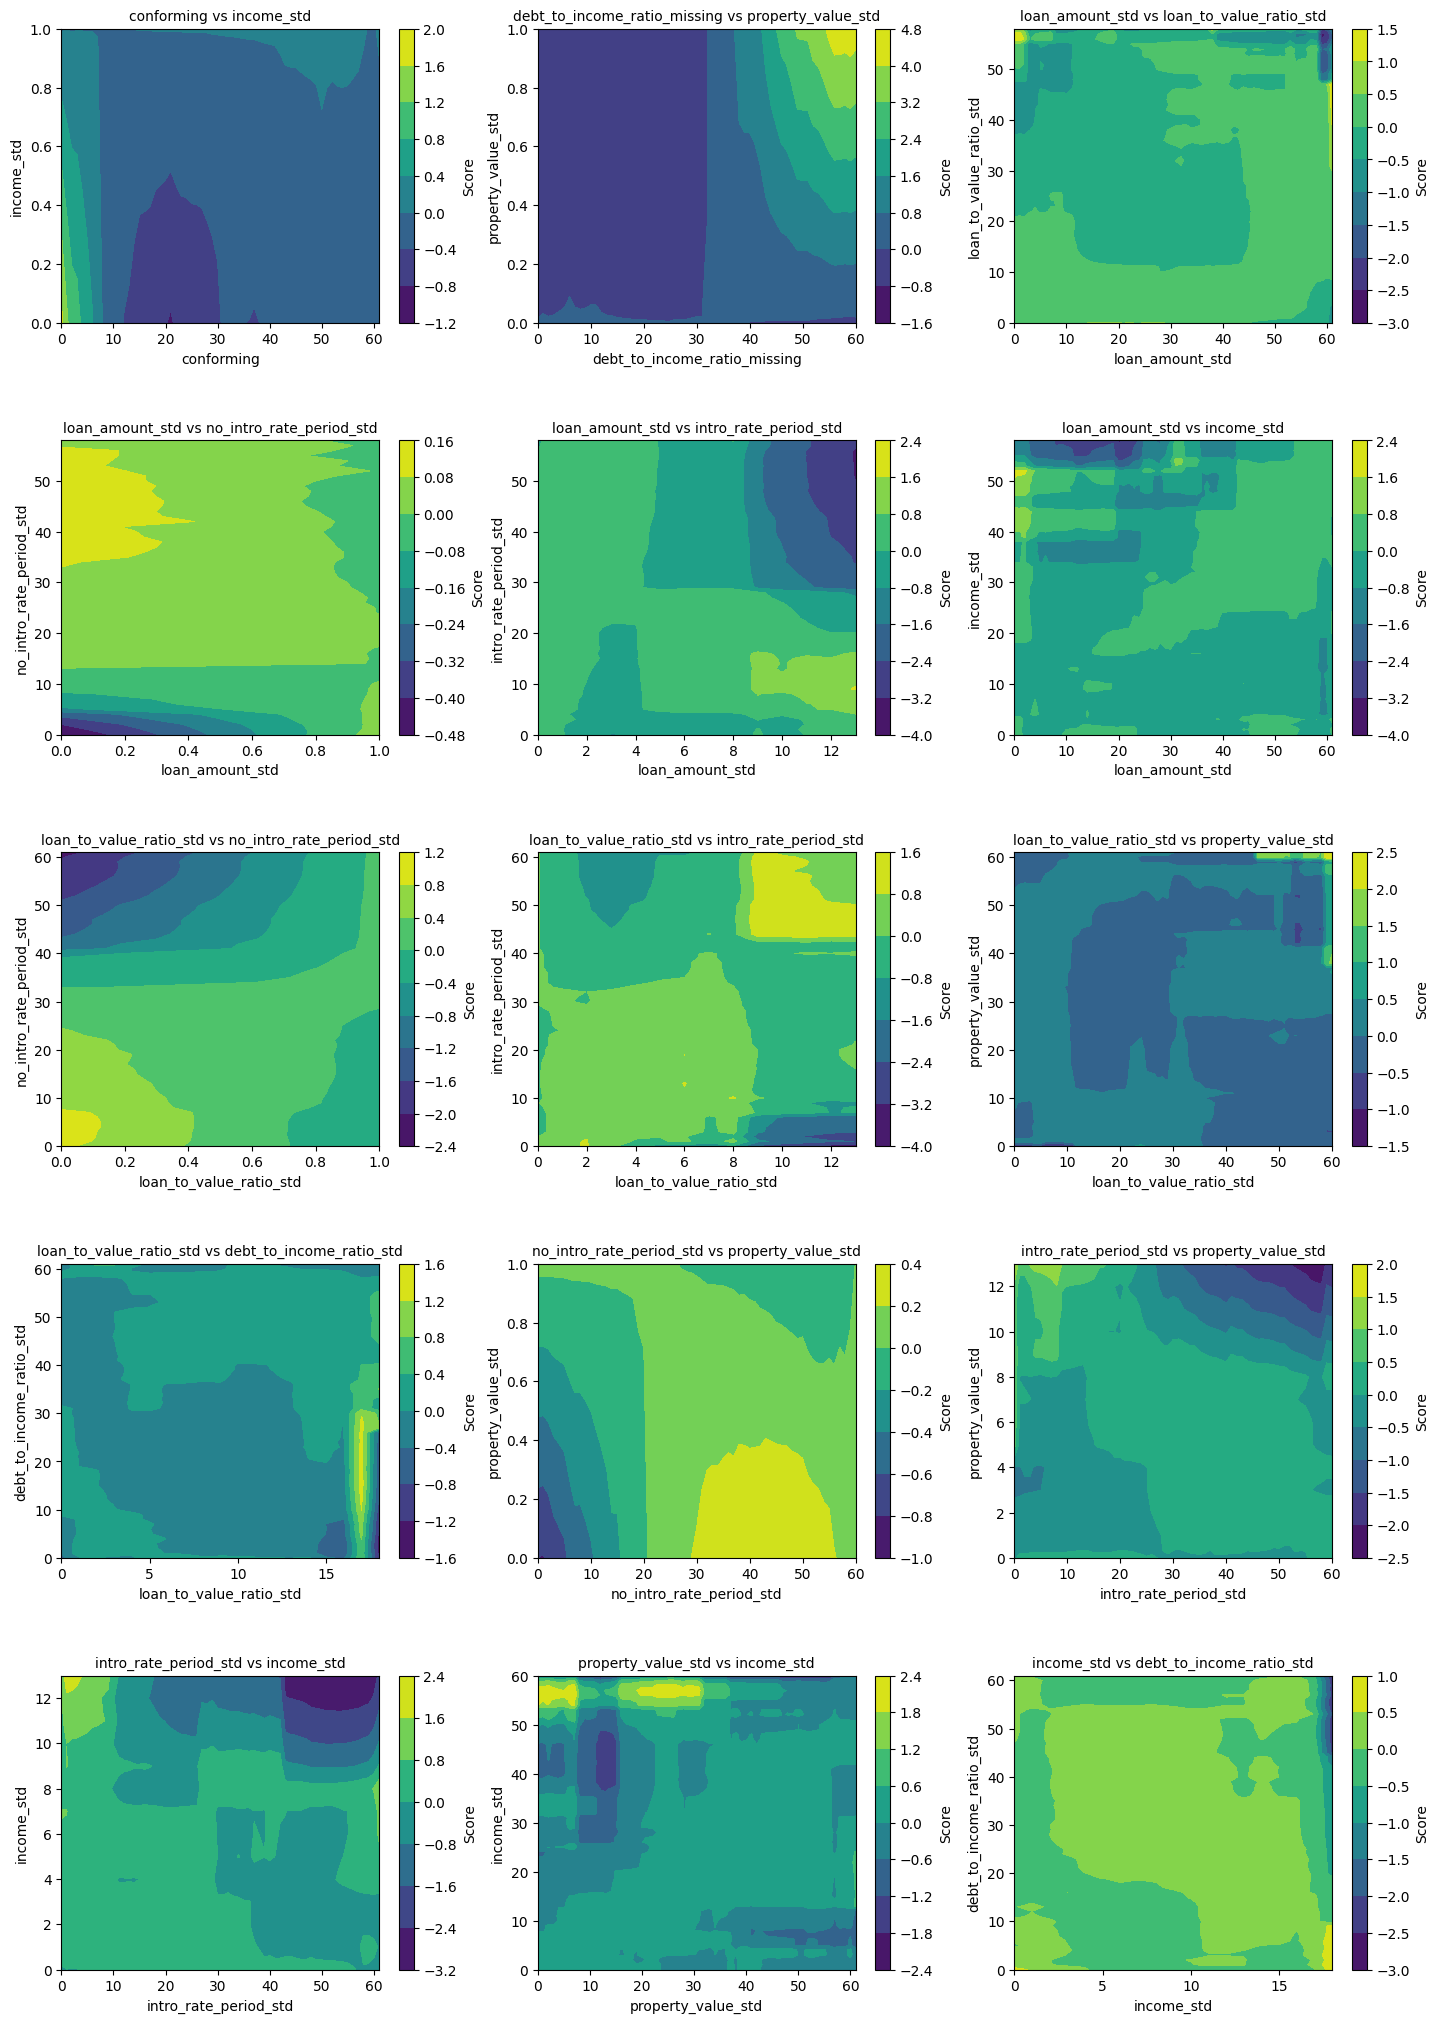

In [37]:
# Get global explanation
ebm_global = best_ebm.explain_global()
global_data = ebm_global.data()

# Extract feature names and identify interactions
names = global_data['names']
interaction_indices = [i for i, name in enumerate(names) if ' & ' in name]
n_interactions = len(interaction_indices)

# Dynamically determine grid size
n_cols = 3  # Fixed number of columns
n_rows = (n_interactions + n_cols - 1) // n_cols  # Ceiling division to fit all plots
figsize_width = 15  # Consistent with previous width for 3 columns
figsize_height = n_rows * 4  # Adjust height based on number of rows (4 units per row)

# Set up a grid of subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(figsize_width, figsize_height), sharey=False)
plt.tight_layout()  # Automatically adjusts spacing
plt.subplots_adjust(left=0.05, right=0.95, wspace=0.2, hspace=0.4)  # Tight spacing from previous plots

# Flatten axes array for easier iteration (handles 2D array)
axes_flat = axes.flatten() if n_rows > 1 else [axes] if n_interactions == 1 else axes

# Iterate over all interaction terms and plot in the grid
for i, idx in enumerate(interaction_indices):
    # Get detailed data for this interaction
    interaction_data = ebm_global.data(idx)

    # Extract feature names
    feature1, feature2 = names[idx].split(' & ')

    # Extract scores (2D array)
    scores = interaction_data['scores']
    if scores.ndim == 1:
        n_bins = int(np.sqrt(len(scores)))
        scores = scores.reshape(n_bins, n_bins)

    # Plot contour on the current subplot
    ax = axes_flat[i]
    contour = ax.contourf(scores, cmap='viridis')
    ax.set_xlabel(feature1)
    ax.set_ylabel(feature2)
    ax.set_title(f'{feature1} vs {feature2}', fontsize=10)
    fig.colorbar(contour, ax=ax, label='Score')  # Add colorbar to each subplot

# Hide any unused subplots
for j in range(i + 1, len(axes_flat)):
    axes_flat[j].axis('off')

# Display the entire figure
plt.show()

#### End timer

In [38]:
toc = time.time() - tic
print('All tasks completed in %.2f s.' % (toc))

All tasks completed in 3402.32 s.


#### Shutdown h2o

In [39]:
h2o.cluster().shutdown(prompt=False)

H2O session _sid_b036 closed.
